- 해당 노트북은 "Deep contextualized word representations" 논문을 기반으로 합니다.
- 피피티와 코드 구현의 아이디어를 https://aisc.a-i.science/events/2018-06-04/ 사이트와 http://mlgalaxy.blogspot.com/2018/12/elmo-deep-contextualized-word.html , https://www.mihaileric.com/posts/deep-contextualized-word-representations-elmo/사이트를 참고하였습니다.

## ELMO 구현에 대한 프로세스를 나열해보자
- Character-based CNN 을 training 합니다.(Yoon kim (2015),"Character-Aware Neural Language Models"의 아키텍처를 사용합니다.)
- 그 후에, 논문 내의 Equation 1 을 통해, $ELMO_{k}$를 생성해줍니다.
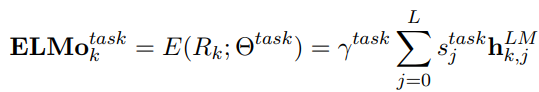

- 우리의 주된 목적은 "Pre-trained bidirectional language model architecture" 입니다. 즉, 나중에 사용할 ELMO 아키텍처를 만들어 놓는다는 것이죠.
- 논문에 나온 표현을 직접 인용해 보면 아래와 같습니다.
- `The pre-trained biLMs in this paper are similar to the architectures in Jozefowicz et al. ´ (2016) and Kim et al. (2015), but modified to support joint training of both directions and add a residual connection between LSTM layers`
- 즉, Char-CNN architecture를 구축하되, 이를 양방향 LSTM 으로 쌓고, 두 개의 레이어 사이에, residul connection을 취하면 되는 형식인 것이죠. 이는, 두 개의 레이어가 한 번에 학습되는 것이 아닌, 독립적인 각 레이어가 스택되는 형태로 이뤄져 있기 때문에, 각각의 레이어를 1개로 선언한 후에,(num_layers = 1) residual connection 을 취해주면서 연결해주면 됩니다.
- 이렇게, Char-CNN architecture를 학습시키고 난 후에, 모든 internal layer가 [sequence length,2(num_layers)] 의 형태로 존재할텐데, 이를 위의 등식으로 더해주어서 $ELMO_{k}^{task}$를 생성해주면 됩니다.

아래의 이미지는, 전체 Language Modeling 의 아키텍처를 설명한 그래프입니다. BiLM을 학습한 이후에, 양방향 히든 레이어를 각각의 인덱스별로 zip해서 concat 하는 것을 볼 수 있는데, 이는 pytorch LSTM 메소드의 argument를 `bidirectional = True` 했을 때의 값과 동일합니다.
여기서 $h_{0}$ 는 $x_{k}$ 즉, character embedding된 input을 의미합니다.
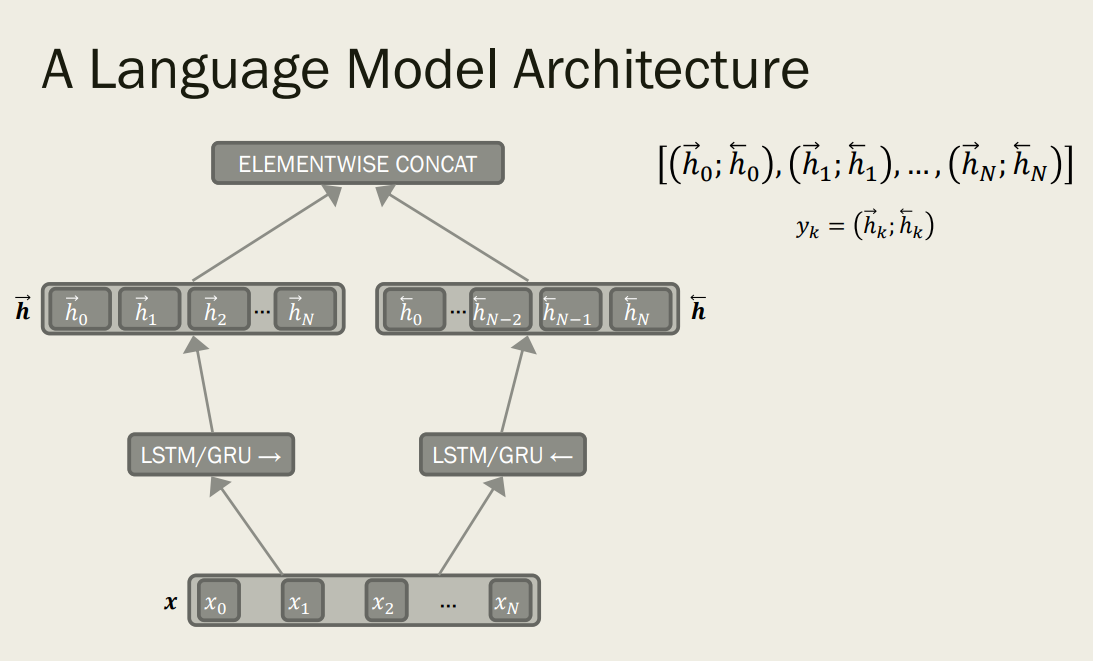

따라서, ELMO 임베딩을 완성하기 위한, 아래의 식을 구현하기 위해서는, 인풋 임베딩인 $x_{k}$와 양방향 LSTM 의 모든 히든 레이어인 $h_{l}$을 softmax 가중합을 취해주어야 하기 때문에, 차원이 같아야 합니다.
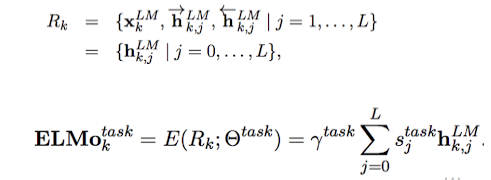

아래의 그래프에서 인풋 임베딩이 512차원으로(hyperparameter) 주어졌고, biLM의 히든 레이어 또한, projection layer를 통해 512가 되기 때문에, 이와 같이 차원을 맞춰주고, 가중합 취해주면 됩니다.
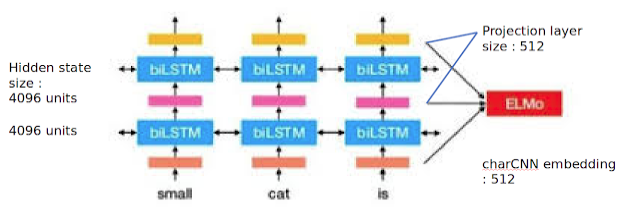

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import datasets

import spacy

import random
import math
import os
import time

SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Constructing the Dataset
- fields 객체는 raw data 를 어떻게 가져올 지에 대한 선언이 담겨있습니다.
- TabularDataset 객체를 통해서, 어디서, 어떤 데이터를 가져올 지에 대해 선언을 해줍니다.
- 아래의 소스코드를 통해 형성된 객체는 generator 의 형태를 띕니다.

In [2]:
# set up fields
TEXT = data.Field(sequential=True, lower=True,init_token='<sos>',eos_token='<eos>')
LABEL = data.Field(sequential=False)

# make splits for data
train, test = datasets.IMDB.splits(TEXT, LABEL)

# build the vocabulary
TEXT.build_vocab(train);TEXT.build_vocab(test)
LABEL.build_vocab(train);LABEL.build_vocab(test)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)
# make iterator for splits
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=3, device=device)

cuda:0


In [3]:
batch = next(iter(train_iter))
batch.text.size()

torch.Size([429, 3])

- TabularDatset 을 통해서, tokenizing 까지는 되었지만, word_to_integar process는 아직 이뤄지지 않았습니다. 
- 우리의 경우, train , text 데이터 셋에 대해서 TEXT 부분에 대해서, word_to_integar converting이 필요합니다.
- `TEXT.build_vocab(trn)` 이라는 코드를 통해, converting이 가능합니다.
- 위의 연산은 모든 training set에 있는 모든 엘리먼트들을 torchtext로 만들어줍니다. Torchtext는 vocabulary를 핸들링하는 Vocab이라는 클래스를 가지고 있습니다. Vocab클래스는 word와 id를 stoi attribute에서 mapping 시켜주고, itos attribute에서는 reverse mapping시켜줍니다.
- stoi : word_to_idx default dictionary 
- itos : word list

word dictionary를 만들어줍니다.

In [4]:
word_to_idx_dict = dict(TEXT.vocab.stoi)

In [5]:
count = 0
idx_to_word_dict = {}

for val,idx in word_to_idx_dict.items() : 
    idx_to_word_dict[count] = val
    count += 1

character dictionary를 만들어줍니다.

In [6]:
word_list = list(word_to_idx_dict.keys())[4:]
char_dict = {}
# char_dict['<unk>'] = 0
# char_dict['<pad>'] = 1
# char_dict['<sos>'] = 2
# char_dict['<eos>'] = 3

count = 1

for word in word_list : 
    for char in word : 
        if char not in char_dict.keys() :
            count += 1
            char_dict[char] = count


word를 character level로 numericalize하는 클래스입니다.

In [37]:
class CharacterIndex_for_SINGLE() : 
    
    def __init__(self,idx_to_word_dict,char_dict,max_length=10,batch_size=3) :
    
        self.batch_size = batch_size
        self.idx_to_word_dict = idx_to_word_dict
        self.char_dict = char_dict
        self.max_length = max_length
    def return_char_idx(self,text) : 

        inputs_ = []
    
        for idx1 in range(self.batch_size) : 
            inputs_.append([char_dict[i] for i in idx_to_word_dict[text[idx1].item()]])
        
        for idx,val in enumerate(inputs_) : 
            if len(val) <= self.max_length :
                inputs_[idx] = val + [1]*(self.max_length - len(val))
            else : 
                inputs_[idx] = val[:self.max_length]
        
        t = torch.tensor(inputs_)
        return t.to(device)

## Hyperparameters

In [44]:
word_dict = word_to_idx_dict
character_dict = char_dict
idx_to_word_dict = idx_to_word_dict
char_embed_size = 15
kernel_size = [1,2,3,4,5]
num_filter = 20
dropout = 0.5
lstm_hidden_size = 1024
elmo_embed_size = 512


_______________

In [45]:
class Highway(nn.Module):
    """Highway network"""
    def __init__(self, input_size):
        super(Highway, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size, bias=True).to(device)
        self.fc2 = nn.Linear(input_size, input_size, bias=True).to(device)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x)).to(device)
        return torch.mul(x, F.relu(self.fc2(x))) + torch.mul(1-x, x)


class Character_Embedding(nn.Module) : 
    
    def __init__(self,character_dict,idx_to_word_dict,char_embed_size,\
                 kernel_size,num_filter,dropout) : 
        
        super(Character_Embedding, self).__init__()
        
        self.char_vocab_size = len(character_dict)
        self.idx_to_word_dict = idx_to_word_dict
        self.char_embed_size = char_embed_size 
        self.dropout = dropout 
        self.char_to_idx = CharacterIndex_for_SINGLE(idx_to_word_dict,character_dict)
        self.embedding = nn.Embedding(
            num_embeddings = self.char_vocab_size,
            embedding_dim = char_embed_size,
            padding_idx = 1).to(device)

        
        self.kernel_size = kernel_size            
        self.num_filter = num_filter         
        self.convs = nn.ModuleList([(nn.Conv2d(in_channels = 1,out_channels = self.num_filter,\
        kernel_size = (kernel,self.char_embed_size))) for kernel in self.kernel_size]).to(device)        
        
        self.fc = nn.Linear(len(kernel_size)*num_filter,elmo_embed_size).to(device)
        self.highway = Highway(elmo_embed_size).to(device)
                
    def forward(self,x) : 
                
        # x : [batch_size]
        char_x = self.char_to_idx.return_char_idx(x) # char_idx : [batch_size, max_length]
        
        (batch_size,max_length) = char_x.size()
        
        embed = self.embedding(char_x) # embed : [batch_size,max_length, embed_dim]
        embed = embed.unsqueeze(1) # embed : [batch_size,1,max_length, embed_dim]
        
        convolution = [conv(embed).squeeze(3) for conv in self.convs]
#         [torch.Size([batch_size, num_filter, filter_width+embed_dim-1])

        pooled = [F.max_pool1d(conv,(conv.size(2))).squeeze(2) for conv in convolution]
#         [torch.Size([batch_size, num_filter])

        cat_mat = torch.cat(pooled,dim=1)
#         [torch.Size([batch_size, num_filter * len(kernel_size)])
        proj = self.fc(cat_mat)
        highway_net1 = self.highway(proj)
        highway_net2 = self.highway(highway_net1)
#         [batch_size, elmo_embed_size]

        return highway_net2

In [46]:
char_embedding = Character_Embedding(character_dict,idx_to_word_dict,char_embed_size,\
                 kernel_size,num_filter,dropout)

In [47]:
char_embedding(batch.text[0]).size()

torch.Size([3, 512])

In [48]:
class BiLM(nn.Module) : 
    
    def __init__(self) : 
        super(BiLM,self).__init__()
        self.proj1 = nn.Linear(elmo_embed_size,lstm_hidden_size).to(device) #
        self.proj2 = nn.Linear(lstm_hidden_size*2,elmo_embed_size).to(device)
        # bilm layer 사이에 projection layer를 삽입해줍니다.
        self.dropout = dropout
        self.lstm_hidden_size = lstm_hidden_size

        self.lstm_l1 = nn.LSTM(input_size=lstm_hidden_size, 
                        hidden_size=lstm_hidden_size, 
                        dropout=dropout,
                        batch_first=True,
                        bidirectional=True).to(device)

        self.lstm_l2 = nn.LSTM(input_size=lstm_hidden_size, 
                        hidden_size=lstm_hidden_size, 
                        dropout=dropout,
                        batch_first=True,
                        bidirectional=True).to(device)
        self.fc = nn.Linear(elmo_embed_size,len(idx_to_word_dict)).to(device)
        
    def forward(self,embeds,hidden) : 
        inputs_bf_proj = embeds.clone()
        # projection 전의 input, 여기서는 character CNN 임베딩 벡터입니다.
        
        inputs_af_proj = self.proj1(inputs_bf_proj).unsqueeze(1)
        # projection 이후의 input, 512 -> 2048 [batch_size , 2048]

        outputs_1l,_ = self.lstm_l1(inputs_af_proj,hidden)
        # [batch_size, 1, lstm_hidden_size * 2] [batch_size , 1, 4096]

        outputs_1l = self.proj2(outputs_1l) + inputs_bf_proj.unsqueeze(1) 
        # residual connection, projection 전의 512 차원을 가진 inputs과 더해주어야 합니다. [batch_size , 512]

        inputs_af_proj = self.proj1(outputs_1l)
        # 두 번째 LSTM 에 넣어주기 위해 다시, 4096으로 projection합니다. [batch_size, 2048]

        outputs_2l,_ = self.lstm_l2(inputs_af_proj,hidden) #[batch_size , 4096]
        
        outputs_2l = self.proj2(outputs_2l)
        # residual connection layer between first and second 에만 적용됩니다. [batch_size, 1, 512]
        outputs = self.fc(outputs_2l.squeeze(1))
        # language modeling을 training 하기 위해서는, fully connect를 통해
        # 차원을 output vocab size 로 expanding시켜주어야 합니다. [batch_size , len(word_dict)]
        return outputs, hidden, outputs_1l, outputs_2l

In [49]:
model = BiLM()
model

BiLM(
  (proj1): Linear(in_features=512, out_features=1024, bias=True)
  (proj2): Linear(in_features=2048, out_features=512, bias=True)
  (lstm_l1): LSTM(1024, 1024, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm_l2): LSTM(1024, 1024, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=247651, bias=True)
)

In [50]:
hidden = torch.zeros(2,3,lstm_hidden_size).to(device)
cell = torch.zeros(2,3,lstm_hidden_size).to(device)
hiddens = (hidden,cell)

embeds = char_embedding(batch.text[0])
outputs, hidden, outputs_1y, outputs_2y = BiLM()(embeds,hiddens)
outputs.size(), hidden[0].size(), outputs_1y.size(), outputs_2y.size()

(torch.Size([3, 247651]),
 torch.Size([2, 3, 1024]),
 torch.Size([3, 1, 512]),
 torch.Size([3, 1, 512]))

In [51]:
class ELMO(nn.Module) : 
    
    def __init__(self) : 
        super(ELMO,self).__init__()
        self.char_embedding = Character_Embedding(character_dict,idx_to_word_dict,char_embed_size,\
                 kernel_size,num_filter,dropout)
        self.bilm = BiLM()
        self.teacher_forcing_ratio = 0.5
    def forward(self,x) : 
        
        (max_len,batch_size) = x.size()
        
        hidden = torch.zeros(2,batch_size,lstm_hidden_size).to(device)
        cell = torch.zeros(2,batch_size,lstm_hidden_size).to(device)
        hiddens = (hidden,cell)
    
        input_ = x[0] # 하나의 batch는 문장이 들어갑니다. 하지만 language modeling은 word별로 state가 업데이트됩니다.
        
        outputs = torch.zeros(max_len, batch_size, len(word_to_idx_dict)).to(device) # output hidden을 저장할 곳
        base_layer = torch.zeros(max_len, batch_size, elmo_embed_size).to(device) #  h_0k 을 저장할 곳
        first_layer = torch.zeros(max_len, batch_size, elmo_embed_size).to(device) # h_1k 을 저장할 곳
        second_layer = torch.zeros(max_len, batch_size, elmo_embed_size).to(device) # h_2k 을 저장할 곳

        for t in range(1, max_len):
#             if t % 100 == 0 : print("전체 문장 길이 {} 중, {}번째 단어 스텝입니다.".format(max_len,t))
            # for 문이 돈다는 것은, many-to-many의 네트워크가 한 칸씩 옆으로 이동한다는 뜻과 같습니다.
            
            embeds = self.char_embedding(input_).to(device)
            output, hiddens, outputs_1y, outputs_2y = self.bilm(embeds,hiddens)
            
            outputs[t] = output
            base_layer[t] = embeds
            first_layer[t] = outputs_1y.squeeze(1)
            second_layer[t] = outputs_2y.squeeze(1)
            teacher_force = random.random() < self.teacher_forcing_ratio
            top1 = output.max(1)[1] # 해당 글자의 numericalized index 를 넣어주어야 합니다.
            input_ = (x[t] if teacher_force else top1)
            
        return outputs , base_layer, first_layer, second_layer        

In [52]:
ELMO()

ELMO(
  (char_embedding): Character_Embedding(
    (embedding): Embedding(145, 15, padding_idx=1)
    (convs): ModuleList(
      (0): Conv2d(1, 20, kernel_size=(1, 15), stride=(1, 1))
      (1): Conv2d(1, 20, kernel_size=(2, 15), stride=(1, 1))
      (2): Conv2d(1, 20, kernel_size=(3, 15), stride=(1, 1))
      (3): Conv2d(1, 20, kernel_size=(4, 15), stride=(1, 1))
      (4): Conv2d(1, 20, kernel_size=(5, 15), stride=(1, 1))
    )
    (fc): Linear(in_features=100, out_features=512, bias=True)
    (highway): Highway(
      (fc1): Linear(in_features=512, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (bilm): BiLM(
    (proj1): Linear(in_features=512, out_features=1024, bias=True)
    (proj2): Linear(in_features=2048, out_features=512, bias=True)
    (lstm_l1): LSTM(1024, 1024, batch_first=True, dropout=0.5, bidirectional=True)
    (lstm_l2): LSTM(1024, 1024, batch_first=True, dropout=0.5, bidirectional=True)
    (fc): Linear(in_f

In [53]:
outputs , base_layer, first_layer, second_layer = ELMO()(batch.text)

In [54]:
outputs.size(), base_layer.size(), first_layer.size(), second_layer.size()

(torch.Size([429, 3, 247651]),
 torch.Size([429, 3, 512]),
 torch.Size([429, 3, 512]),
 torch.Size([429, 3, 512]))

In [55]:
class fit() : 
    
    def __init__(self, model, train_iter, test_iter, epoch = 5) : 
        
        self.optimizer = optim.Adam(model.parameters())
        # <pad> 토큰은 임베딩 벡터와, loss_function에 argument 로 들어가서, training 과정에서 제외됩니다.
        self.pad_idx = 1 
        self.criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
#         self.device = 'cpu'
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.epoch = epoch
            
    def train(self,clip):
    
        epoch_loss = 0 # loss per epoch
        self.model.train()
        
        for i, batch in enumerate(self.train_iter):
            print('train batch : ',i,end='\r')
            src = batch.text

            self.optimizer.zero_grad()

            output , base_layer, first_layer, second_layer  = self.model(src)        

            loss_output = output[1:].view(-1, output.shape[-1])
            loss_trg = src[1:].view(-1)
            # sos 토큰을 제외하고, 차원을 맞춘 후에, output을 변수에 저장해줍니다.
            
            loss = self.criterion(loss_output, loss_trg)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # gradient clipping
            self.optimizer.step()
            
            epoch_loss += loss.item()
        
        return epoch_loss / len(self.train_iter)
    
    def test(self):
    
        epoch_loss = 0 # loss per epoch
        self.model.eval()
        
        for i, batch in enumerate(self.test_iter):
            print('test batch : ',i,end='\r')
            src = batch.src

            output = self.model(src)        

            loss_output = output[1:].view(-1, output.shape[-1]) #[seq_length*batch_size, vocab_size]
            loss_trg = src[1:].view(-1) #[seq_length*batch_size]
            # sos 토큰을 제외하고, 차원을 맞춘 후에, output을 변수에 저장해줍니다.
            
            loss = self.criterion(loss_output, loss_trg)
            epoch_loss += loss.item()
        
        return epoch_loss / len(self.test_iter)

    
    
    def fit_by_iterate(self,clip) : 
        
        for epoch in range(self.epoch):
            print('epoch : ',epoch + 1)
            train_loss= self.train(clip)
            print("training loss : {}".format(train_loss))
            
            if epoch == self.epoch :  #마지막에 test를 실행합니다.
                test_loss = self.test()
                print('last test : {}'.format(test_loss))
                
            if (epoch % 5 == 0) and (epoch != 0): #5의 배수 epoch마다 test를 실행합니다.
                test_loss = self.test()
                print('testing loss : {}'.format(test_loss))

In [ ]:
fitting_process = fit(ELMO(),train_iter,test_iter,epoch=5)
fitting_process.fit_by_iterate(1)

ELMO 임베딩을 freezing한 후에 특정 task에 대해서 ELMO 레이어 별로 가중치 s를 학습을 합니다. lambda 는 Task 별로 다른 constant 를 할당합니다.